In [247]:
import torch
import torch.nn as nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch.utils
import torch.utils.data

from torchmetrics import Accuracy

from timeit import default_timer as timer

from tqdm.auto import tqdm

from torchinfo import summary

import random
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

In [248]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

DEVICE

'cuda'

In [249]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else: 
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and suhsi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
  print("Downloading pizza, steak, suhsi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

data\pizza_steak_sushi directory already exists... skipping download
Unzipping pizza, steak and sushi data...


In [250]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [251]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [252]:
class ImageFolderCustomDataset(Dataset):
    def __init__(self, target_dir: str, transform = None):
        super().__init__()
        self.paths = list(Path(target_dir).rglob("*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = self.find_classes(target_dir)
    
    def find_classes(self, directory: str) -> tuple[list[str], dict[str, int]]:
        classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
        if not classes:
            raise FileNotFoundError(f"Could not find any class in {directory}")
        
        class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
        return classes, class_to_idx
    
    def load_image(self, index: int) ->Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)
    
    def __len__(self) -> int:
        return len(self.paths)
    
    def __getitem__(self, index: int) -> tuple[torch.Tensor, int]:
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            img = self.transform(img)
        return img, class_idx

In [253]:
train_transforms = transforms.Compose([transforms.Resize(size=(64, 64)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                      transforms.ToTensor()])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()])

In [254]:
train_data_customDataset = ImageFolderCustomDataset(target_dir=train_dir, transform=train_transforms)
test_data_customDataset = ImageFolderCustomDataset(target_dir=test_dir, transform=test_transform)

len(train_data_customDataset), len(test_data_customDataset)

(450, 150)

In [255]:
def display_random_images(dataset: torch.utils.data, classes: list[str]=None, n: int=10, display_shape: bool = True, seed: int=None):
     if n > 10:
        n = 10
        display_shape = False
        print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

     if seed:
         random.seed(seed)
     
     random_samples_idx = random.sample(range(len(dataset)), k=n)

     plt.figure(figsize=(16, 8))

     for i, target_sample in enumerate(random_samples_idx):
         targ_image, targ_label = dataset[target_sample][0], dataset[target_sample][1]
    
         targ_image_adjust = targ_image.permute(1, 2, 0)


         plt.subplot(1, n, i+1)
         plt.imshow(targ_image_adjust)
         plt.axis("off")
         if classes:
             title = f"Class: {classes[targ_label]}"
         if display_shape:
             title = title + f"\nshape: {targ_image_adjust.shape}"
             plt.title(title)     

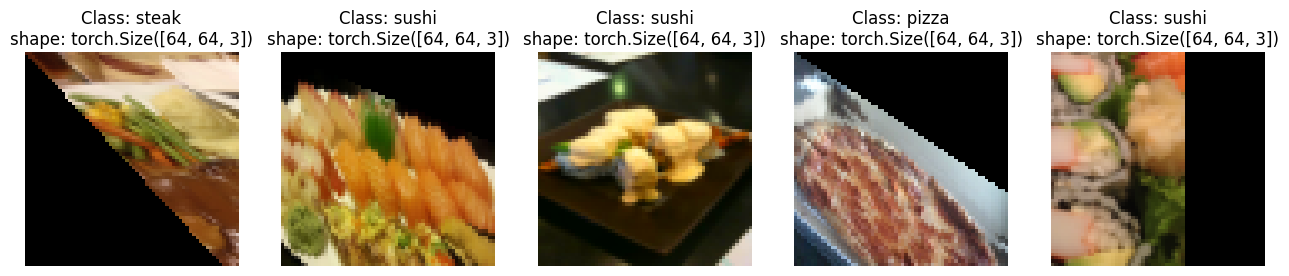

In [256]:
display_random_images(train_data_customDataset,
                      n=5, 
                      classes=train_data_customDataset.classes,
                      seed=None)

In [257]:
accuracy = Accuracy(task="multiclass", num_classes=10).to(DEVICE)

def train_step(model: nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, device=DEVICE):
    
    model.train()
    train_accTorchMetric = 0
    train_loss = 0

    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_accTorchMetric += accuracy(y_pred.argmax(dim=1), y)
        train_loss += loss.item()

        optimizer.zero_grad(set_to_none=True)

        loss.backward()

        optimizer.step()
    train_accTorchMetric /= len(dataloader)
    print (f"TrainAccuracy:: {train_accTorchMetric *100:.2f}%")
    return train_loss, train_accTorchMetric

def test_step(model: nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, device=DEVICE):
    
    model.eval()
    test_accTorchMetric = 0
    test_loss = 0
    
    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
            test_accTorchMetric+= accuracy(y_pred.argmax(dim=1), y)

        test_accTorchMetric /= len(dataloader)
        print (f"TestAccuracy:: {test_accTorchMetric *100:.2f}%")
        return test_loss, test_accTorchMetric

In [258]:


def train_model_epochs(model: nn.Module, train_dataloader: torch.utils.data.DataLoader, test_dataloader: torch.utils.data.DataLoader, loss_fn: nn.Module, optimizer: torch.optim.Optimizer, writer: torch.utils.tensorboard.SummaryWriter, device=DEVICE, epochs: int=10) -> dict[str, list[float]]:
    results = {"train_loss": [],
               "train_accuracy": [],
               "test_loss": [],
               "test_accuracy": []}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model, dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, device=DEVICE)
        test_loss, test_acc = test_step(model=model, dataloader=test_dataloader, loss_fn=loss_fn, device=DEVICE)

        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_accuracy"].append(test_acc)

        #Experiment Tracking
        if writer:
            writer.add_scalars(main_tag="Loss", tag_scalar_dict={"train_loss": train_loss, "test_loss": test_loss}, global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", tag_scalar_dict={"train_acc": train_acc, "test_acc": test_acc}, global_step=epoch)
            writer.add_graph(model=model, input_to_model=torch.randn(32, 3, 224, 224).to(device))
            writer.close()
        else:
            pass
    
    writer.close()

    return results


In [259]:
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
weights

EfficientNet_B2_Weights.IMAGENET1K_V1

In [260]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [261]:
train_data_customDataset = ImageFolderCustomDataset(target_dir=train_dir, transform=auto_transforms)
test_data_customDataset = ImageFolderCustomDataset(target_dir=test_dir, transform=auto_transforms)

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data_customDataset, shuffle=True, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(dataset=test_data_customDataset, shuffle=False, batch_size=BATCH_SIZE)

print(f"train_data_customDataset={len(train_data_customDataset)} ,,, test_data_customDataset={len(test_data_customDataset)} \n train_dataloader={len(train_dataloader)} ,,, test_dataloader={len(test_dataloader)}")

train_data_customDataset=450 ,,, test_data_customDataset=150 
 train_dataloader=15 ,,, test_dataloader=5


In [262]:
model_1 = torchvision.models.efficientnet_b2(weights=weights).to(DEVICE)

summary(model=model_1, input_size=[32, 3, 224, 224], 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [263]:
for param in model_1.features.parameters():
    param.requires_grad = False

summary(model=model_1, input_size=[32, 3, 224, 224], 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [264]:
model_1.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [265]:
model_1.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1408, out_features=len(train_data_customDataset.classes))
)

model_1.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1408, out_features=3, bias=True)
)

In [266]:
summary(model=model_1, input_size=[32, 3, 224, 224], 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [267]:
def create_writer(experiment_name: str, model_name: str, extra: str = None):
    from datetime import datetime
    import os

    timestamp = datetime.now().strftime("%Y-%m-%d")

    if extra:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
    return SummaryWriter(log_dir=log_dir)

In [268]:
loss_fn =  nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr = 0.001)


start_time = timer()

training_results=train_model_epochs(model=model_1, train_dataloader=train_dataloader, test_dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optimizer, 
                                    writer= create_writer(experiment_name="EfB2", model_name="EfficientNetB2", extra=f"{5}_epochs"),
                                      device=DEVICE, epochs=5)

end_time = timer()

print(f"StartTime={start_time:.3f} _____ EndTime={end_time:.3f} ____ TotalTimeTook={end_time-start_time:.3f}")

  0%|          | 0/5 [00:00<?, ?it/s]

TrainAccuracy:: 58.33%
TestAccuracy:: 90.40%


 20%|██        | 1/5 [00:04<00:17,  4.42s/it]

TrainAccuracy:: 80.83%
TestAccuracy:: 92.90%


 40%|████      | 2/5 [00:09<00:14,  4.71s/it]

TrainAccuracy:: 85.83%
TestAccuracy:: 96.25%


 60%|██████    | 3/5 [00:14<00:09,  4.70s/it]

TrainAccuracy:: 86.46%
TestAccuracy:: 93.81%


 80%|████████  | 4/5 [00:18<00:04,  4.70s/it]

TrainAccuracy:: 86.04%
TestAccuracy:: 96.59%


100%|██████████| 5/5 [00:23<00:00,  4.70s/it]


StartTime=46304.978 _____ EndTime=46328.505 ____ TotalTimeTook=23.527


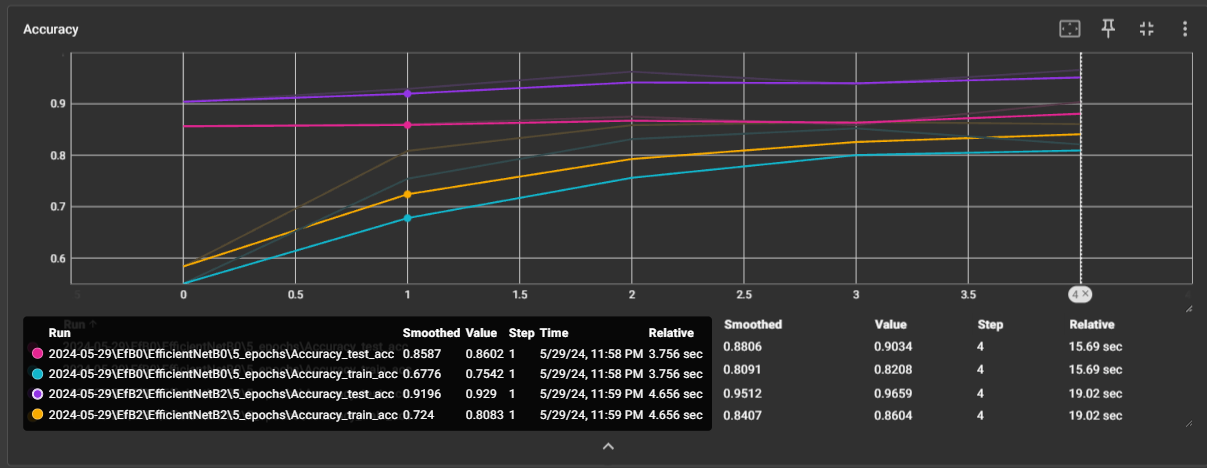

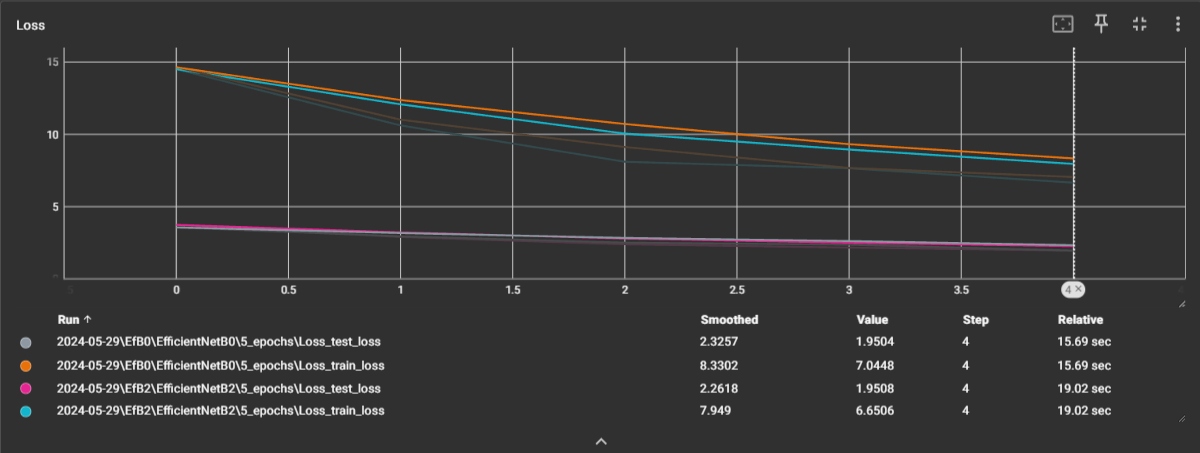